In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import skimage.color as color

from torch.utils.data import DataLoader
from torchvision import datasets as dsets, transforms as tf
from torchvision.utils import make_grid
from collections import OrderedDict

In [2]:
data_root = '/Datasets/CIFAR10/.'
data_root_places = '/Datasets/Places365/train/.'
workers = 0
lr = 1e-4
nc=3
nz=3
nf = 64
beta1 = 9e-1
batch_limit = 1000
weight_decay = 1e-3

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda else 'cpu')
device

device(type='cuda', index=0)

In [4]:
class RGB2LAB(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))

In [5]:
def lab2rgb(image, dim=None):
    """
    :param image is a single Lab image the shape of (X, y, 3)
    :param dim to define the color-channel dimension.
    """
    image = np.transpose(image, axes=(1, 2, 0))

    if dim is not None:
        z = np.zeros_like(image)
        if dim != 0:
            z[:, :, 0] = 80  # Increase the brightness to see other color channels(a & b).

        z[:, :, dim] = image[:, :, dim]
        return color.lab2rgb(z)
    else:
        return color.lab2rgb(image)

In [6]:
transforms = {
    'mnist': tf.Compose([
        tf.ToTensor()
    ]),
    'cifar': tf.Compose([
        tf.ToTensor()
    ]),
    'places365': tf.Compose([
        RGB2LAB(),
        tf.ToTensor()
    ])
}

In [7]:
train_dataset = dsets.CIFAR10(root=data_root, train=True, download=True, transform=transforms['cifar'])
test_dataset = dsets.CIFAR10(root=data_root, train=False, download=True, transform=transforms['cifar'])

print(train_dataset, test_dataset, sep='\n\n')

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Datasets/CIFAR10/.
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /Datasets/CIFAR10/.
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [8]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False, num_workers=workers, pin_memory=is_cuda)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=workers, pin_memory=is_cuda)

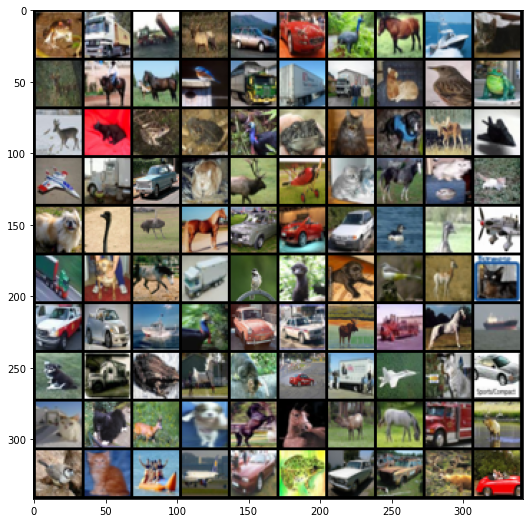

In [9]:
im = next(iter(train_loader))

grid = make_grid(im[0], nrow=10, normalize=True)

plt.figure(figsize=(10 ,9))
plt.imshow(np.transpose(grid, axes=(1, 2, 0)))

In [8]:
class AutoEncoderMNIST(nn.Module):

    def __init__(self, in_channels=nc, out_channels=nz):
        super(AutoEncoderMNIST, self).__init__()
        pad = (0, 1, 0, 1)

        self.encode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=nf, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.Conv2d(in_channels=nf, out_channels=nf * 2, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.Conv2d(in_channels=nf * 2, out_channels=nf * 4, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=(1, 1, 1, 1)),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.Conv2d(in_channels=nf * 4, out_channels=nf * 8, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU()
            ))
        ]))

        self.decode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 4, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 4, out_channels=nf * 2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 2, out_channels=nf, kernel_size=4, stride=2, padding=2),
                nn.BatchNorm2d(nf),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU()
            ))
        ]))

    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


acNet = AutoEncoderMNIST().to(device)
acNet

AutoEncoder(
  (encode): Sequential(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((1, 1, 1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (decode): Sequential(
    (conv1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=

In [19]:
class AutoEncoderCIFAR(nn.Module):

    def __init__(self, in_channels=nc, out_channels=nz):
        super(AutoEncoderCIFAR, self).__init__()
        pad = (0, 1, 0, 1)

        self.encode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=nf, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.Conv2d(in_channels=nf, out_channels=nf * 2, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.Conv2d(in_channels=nf * 2, out_channels=nf * 4, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=(1, 1, 1, 1)),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.Conv2d(in_channels=nf * 4, out_channels=nf * 8, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 8),
            ))
        ]))

        self.decode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 4, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 4, out_channels=nf * 2, kernel_size=4, stride=2, padding=2),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 2, out_channels=nf, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(nf),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU()
            ))
        ]))

    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


acNet = AutoEncoderCIFAR().to(device)
acNet

AutoEncoderCIFAR(
  (encode): Sequential(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((1, 1, 1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decode): Sequential(
    (conv1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
     

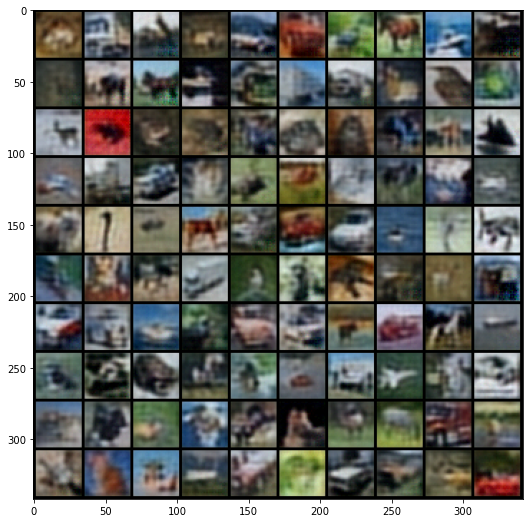

In [24]:
with torch.no_grad():
    x = acNet(im[0].to(device)).cpu()

    grid = make_grid(x, nrow=10, normalize=True)


plt.figure(figsize=(10, 9))
plt.imshow(np.transpose(grid, axes=(1, 2, 0)))

### Train the "AutoEncoder" model.

In [21]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(acNet.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
losses = []
epochs = 10

start = time.time()

is_break = False

WINDOW_NAME = 'Frame'

cv2.namedWindow(WINDOW_NAME, flags=cv2.WINDOW_NORMAL)
cv2.resizeWindow(WINDOW_NAME, width=640, height=640)

for i in range(epochs):
    i += 1

    for batch, x in enumerate(train_loader):
        batch += 1

        x = x[0].to(device)

        optimizer.zero_grad()

        out = acNet(x)
        loss = criterion(out, x)

        if batch == 1 or batch % 500 == 0:
            losses.append(loss)
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        loss.backward()
        optimizer.step()

        grid = make_grid(out.detach().cpu(), nrow=10, normalize=True).numpy()
        grid = cv2.cvtColor(np.transpose(grid, axes=(1, 2, 0)), code=cv2.COLOR_BGR2RGB)

        cv2.imshow(WINDOW_NAME, grid)

        if cv2.waitKey(1) & 0xFF == 27:
            is_break = True
            break

    if is_break:
        cv2.destroyWindow(WINDOW_NAME)
        break


cv2.destroyWindow(WINDOW_NAME)

duration = time.time() - start
print(f'Duration to execute: {duration / 60:.4f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.48741069436073303
Epoch: 1, Batch: 500 -> Loss: 0.015256726182997227
Epoch: 2, Batch: 1 -> Loss: 0.01594456471502781
Epoch: 2, Batch: 500 -> Loss: 0.0101951714605093
Epoch: 3, Batch: 1 -> Loss: 0.011186545714735985
Epoch: 3, Batch: 500 -> Loss: 0.007772700395435095
Epoch: 4, Batch: 1 -> Loss: 0.00909306388348341
Epoch: 4, Batch: 500 -> Loss: 0.006457992363721132
Epoch: 5, Batch: 1 -> Loss: 0.007901945151388645
Duration to execute: 1.5000 minutes


Text(0.5, 1.0, 'Loss x Epochs')

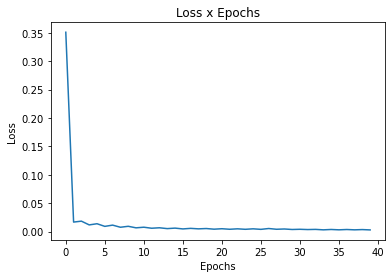

In [22]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss x Epochs')

### Play with Places365 Dataset.

In [10]:
places_train = dsets.ImageFolder(root=data_root_places, transform=transforms['places365'])
places_loader = DataLoader(places_train, batch_size=20, num_workers=workers, pin_memory=is_cuda)

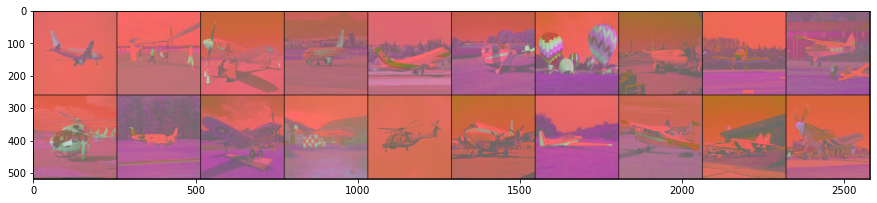

In [11]:
im = next(iter(places_loader))

grid = make_grid(im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(grid, axes=(1, 2, 0)))

In [12]:
def weights_init(m):
    """
    Custom weights initialization for the input tensor call on Generator and Discriminator
    networks' weights of Convolutional, ConvolutionsTranspose and BatchNormalization layers.

    Per the DCGAN paper, all the model weights shall be randomly initialized from a normal
    distribution with mean=0.0 and std=0.02.

    :param m: Network layer object to derive and update weights randomly.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean=0., std=.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, mean=1., std=.02)
        nn.init.constant_(m.bias.data, val=0)

In [13]:
class AutoEncoderPlace365(nn.Module):

    def __init__(self, in_channels=nz, out_channels=nc, pad=(0, 1, 0, 1)):
        super(AutoEncoderPlace365, self).__init__()

        self.encode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=nf, kernel_size=1, stride=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv2', nn.Sequential(
                nn.Conv2d(in_channels=nf, out_channels=nf, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv3', nn.Sequential(
                nn.Conv2d(in_channels=nf, out_channels=nf * 2, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 2),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv4', nn.Sequential(
                nn.Conv2d(in_channels=nf * 2, out_channels=nf * 4, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 4),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv5', nn.Sequential(
                nn.Conv2d(in_channels=nf * 4, out_channels=nf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv6', nn.Sequential(
                nn.Conv2d(in_channels=nf * 8, out_channels=nf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv7', nn.Sequential(
                nn.Conv2d(in_channels=nf * 8, out_channels=nf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv8', nn.Sequential(
                nn.Conv2d(in_channels=nf * 8, out_channels=nf * 8, kernel_size=4, stride=2, bias=False),
                nn.BatchNorm2d(nf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            ))
        ]))

        self.decode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 8, kernel_size=4, stride=2, bias=False),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU(nf * 8),
            )),
            ('conv2', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 16, out_channels=nf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU(),
            )),
            ('conv3', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 16, out_channels=nf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 16, out_channels=nf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv5', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv6', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 4, out_channels=nf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf),
                nn.ReLU()
            )),
            ('conv7', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 2, out_channels=nf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf),
                nn.ReLU()
            )),
            ('parametric', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 2, out_channels=out_channels, kernel_size=1, stride=1, bias=False),
                nn.Tanh()
            ))
        ]))

        self.encode_children = dict(self.encode.named_children())
        self.decode_children = dict(self.decode.named_children())

    def forward(self, x):
        conv1 = self.encode_children['conv1'](x)
        conv2 = self.encode_children['conv2'](conv1)
        conv3 = self.encode_children['conv3'](conv2)
        conv4 = self.encode_children['conv4'](conv3)
        conv5 = self.encode_children['conv5'](conv4)
        conv6 = self.encode_children['conv6'](conv5)
        conv7 = self.encode_children['conv7'](conv6)
        conv8 = self.encode_children['conv8'](conv7)

        conv9 = torch.cat([self.decode_children['conv1'](conv8), conv7], dim=1)
        conv10 = torch.cat([self.decode_children['conv2'](conv9), conv6], dim=1)
        conv11 = torch.cat([self.decode_children['conv3'](conv10), conv5], dim=1)
        conv12 = torch.cat([self.decode_children['conv4'](conv11), conv4], dim=1)
        conv13 = torch.cat([self.decode_children['conv5'](conv12), conv3], dim=1)
        conv14 = torch.cat([self.decode_children['conv6'](conv13), conv2], dim=1)
        conv15 = torch.cat([self.decode_children['conv7'](conv14), conv1], dim=1)
        conv16 = self.decode_children['parametric'](conv15)
        return conv16


acNet365 = AutoEncoderPlace365().to(device)
acNet365.apply(fn=weights_init)
acNet365

AutoEncoderPlace365(
  (encode): Sequential(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReL

torch.Size([20, 3, 256, 256])


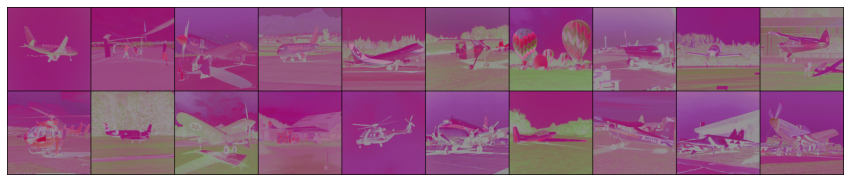

In [14]:
torch.cuda.empty_cache()

with torch.no_grad():
    acNet365.eval()

    x = acNet365(im[0].cuda().float()).cpu()

    print(x.shape)

    grid = make_grid(x, nrow=10, normalize=True)

    plt.figure(figsize=(15, 14))
    plt.imshow(np.transpose(grid, axes=(1, 2, 0)))
    # plt.imshow(lab2rgb(grid) * 50)
    plt.axis('off')

### Train Places365 Model

In [15]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(acNet365.parameters(), lr=lr, betas=(beta1, 0.999))

In [16]:
torch.cuda.empty_cache()

batch_limit = 4000

losses = []
epochs = 4

WINDOW_NAME = "Places365 Frames"

cv2.namedWindow(WINDOW_NAME, flags=cv2.WINDOW_NORMAL)
cv2.resizeWindow(WINDOW_NAME, width=1280, height=256)

is_destroy = False

start = time.time()

acNet365.train()

for i in range(epochs):
    i += 1

    for batch, x in enumerate(places_loader):
        batch += 1

        optimizer.zero_grad()

        x = x[0].to(device).float()

        out = acNet365(x)
        loss = criterion(out, x)

        losses.append(loss)

        if batch == 1 or batch % 200 == 0:
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        grid = torch.stack([x[:, 0] / 100, out.detach()[:, 1], out.detach()[:, 2]], dim=1)

        grid = make_grid(grid.cpu(), nrow=10, normalize=True).numpy()
        grid = cv2.cvtColor(np.transpose(grid, axes=(1, 2, 0)), code=cv2.COLOR_BGR2RGB)

        cv2.imshow(WINDOW_NAME, grid)

        if cv2.waitKey(1) & 0xFF == 27:
            is_destroy = True
            break

        loss.backward()
        optimizer.step()

        if batch_limit == batch:
            break

    if is_destroy:
        cv2.destroyWindow(WINDOW_NAME)
        break

duration = time.time() - start
print(f'Duration to execute: {duration / 60:.4f} minutes')

Epoch: 1, Batch: 1 -> Loss: 1378.440673828125
Epoch: 1, Batch: 200 -> Loss: 1386.0042724609375
Epoch: 1, Batch: 400 -> Loss: 855.4164428710938
Epoch: 1, Batch: 600 -> Loss: 971.3191528320312
Epoch: 1, Batch: 800 -> Loss: 1044.251953125
Epoch: 1, Batch: 1000 -> Loss: 1109.327880859375
Duration to execute: 11.0263 minutes


In [14]:
PATH = '../../ptl/places365.ptl'

torch.save(acNet365.state_dict(), PATH)
# acNet365.load_state_dict(torch.load(PATH))

Text(0.5, 1.0, 'Epochs x Loss')

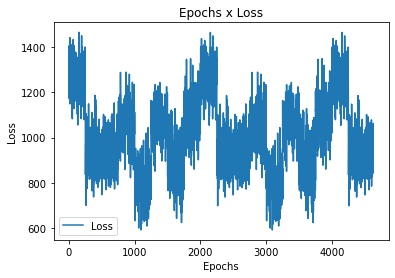

In [15]:
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Epochs x Loss')

In [13]:
cv2.destroyAllWindows()